In [10]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib widget

import numpy as np

C:\Users\yaozi\AppData\Local\Temp\ipykernel_9396\3852520056.py:3: MatplotlibDeprecationWarning: Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
  matplotlib.use('Qt5Agg')


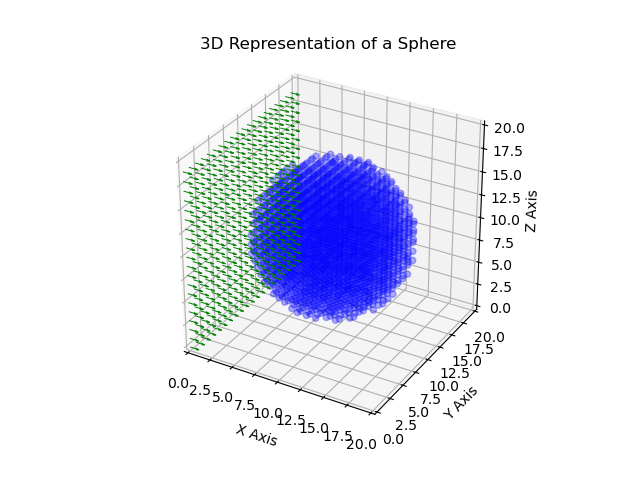

In [11]:
num_x, num_y, num_z = 20, 20, 20
center = (num_x//2, num_y//2, num_z//2)
radius = 8
x, y, z = np.ogrid[:num_x, :num_y, :num_z]
mask = (x - center[0])**2 + (y - center[1])**2 + (z - center[2])**2 <= radius**2
convex_lens_ior_field = np.ones((num_x, num_y, num_z))
convex_lens_ior_field[mask] = 1.5


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_box_aspect([1,1,1])
ax.set_xlim(0, 20)
ax.set_ylim(0, 20)
ax.set_zlim(0, 20)
# IOR field
x_points, y_points, z_points = np.where(convex_lens_ior_field == 1.5)
ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.3)

# Initial wavefront
initial_wavefront_positions = np.array([(0, y, z) for y in range(num_y) for z in range(num_z)])
initial_wavefront_directions = np.array([(1, 0, 0) for _ in range(num_y * num_z)])
ax.quiver(initial_wavefront_positions[:, 0], initial_wavefront_positions[:, 1], initial_wavefront_positions[:, 2], 
          initial_wavefront_directions[:, 0], initial_wavefront_directions[:, 1], initial_wavefront_directions[:, 2],
          length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4)

ax.set_title("3D Representation of a Sphere")
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')
plt.show()

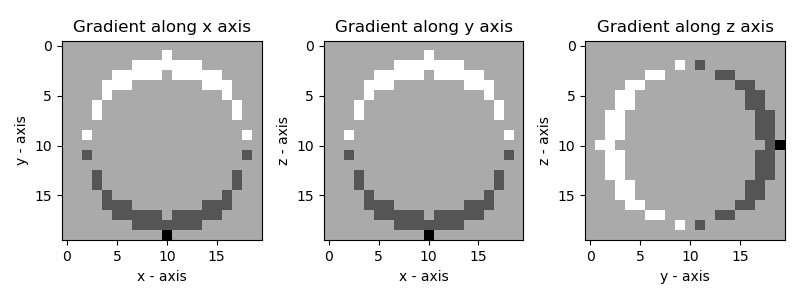

In [12]:
def compute_3d_gradients(IOR):
    grad_x = np.gradient(IOR, axis=0)
    grad_y = np.gradient(IOR, axis=1)
    grad_z = np.gradient(IOR, axis=2)
    return grad_x, grad_y, grad_z

convex_grad_xyz = compute_3d_gradients(convex_lens_ior_field)

grad_x, grad_y, grad_z = convex_grad_xyz

plt.figure(figsize=(8, 3))
plt.subplot(131)
plt.imshow(grad_x[:, :, num_z // 2], cmap='gray')  # Z轴中心切面
plt.title('Gradient along x axis')
plt.xlabel('x - axis')
plt.ylabel('y - axis')

plt.subplot(132)
plt.imshow(grad_y[num_y // 2, :, :], cmap='gray')  # Y轴中心切面
plt.title('Gradient along y axis')
plt.xlabel('x - axis')
plt.ylabel('z - axis')

plt.subplot(133)
plt.imshow(grad_z[:, num_x // 2, :], cmap='gray')  # X轴中心切面
plt.title('Gradient along z axis')
plt.xlabel('y - axis')
plt.ylabel('z - axis')

plt.tight_layout()
plt.show()

In [13]:
def update_wavefront(pos, dir, grad_xyz, IOR, delta_t):
    new_pos = []
    new_dir = []
    grad_x, grad_y, grad_z = grad_xyz
    for (x,y,z), (dx, dy, dz) in zip(pos, dir):
        # x_i+1 = x_i + delta_t * v_i / n^2
        # v_i+1 = v_i + delta_t * grad_n / n
        n = IOR[int(x), int(y), int(z)]
        new_x = x + delta_t * dx / n**2
        new_y = y + delta_t * dy / n**2
        new_z = z + delta_t * dz / n**2
        new_x = np.clip(new_x, 0, IOR.shape[0]-1)
        new_y = np.clip(new_y, 0, IOR.shape[1]-1)
        new_z = np.clip(new_z, 0, IOR.shape[2]-1)
        new_pos.append((new_x, new_y, new_z))

        n_dx = grad_x[int(x), int(y), int(z)]
        n_dy = grad_y[int(x), int(y), int(z)]
        n_dz = grad_z[int(x), int(y), int(z)]
        new_dx = dx + delta_t * n_dx / n
        new_dy = dy + delta_t * n_dy / n
        new_dz = dz + delta_t * n_dz / n
        new_dir.append((new_dx, new_dy, new_dz))

    return new_pos, new_dir

def simulate_wavefront_propagation(cur_IOR, grad_xyz, inital_wavefront_pos, initial_wavefront_dir, num_steps=50, delta_t=1.0):
    wavefront_pos_list = [inital_wavefront_pos]
    wavefront_dir_list = [initial_wavefront_dir]
    for _ in range(num_steps):
        wavefront_positions, wavefront_directions = update_wavefront(wavefront_pos_list[-1], wavefront_dir_list[-1], grad_xyz, cur_IOR, delta_t)
        wavefront_pos_list.append(wavefront_positions)
        wavefront_dir_list.append(wavefront_directions)

    return wavefront_pos_list, wavefront_dir_list


test_num_steps = 50
test_delta_t = 0.6

convex_pos_res, convex_dir_res = simulate_wavefront_propagation(convex_lens_ior_field, convex_grad_xyz, initial_wavefront_positions, initial_wavefront_directions, num_steps=test_num_steps, delta_t=test_delta_t)

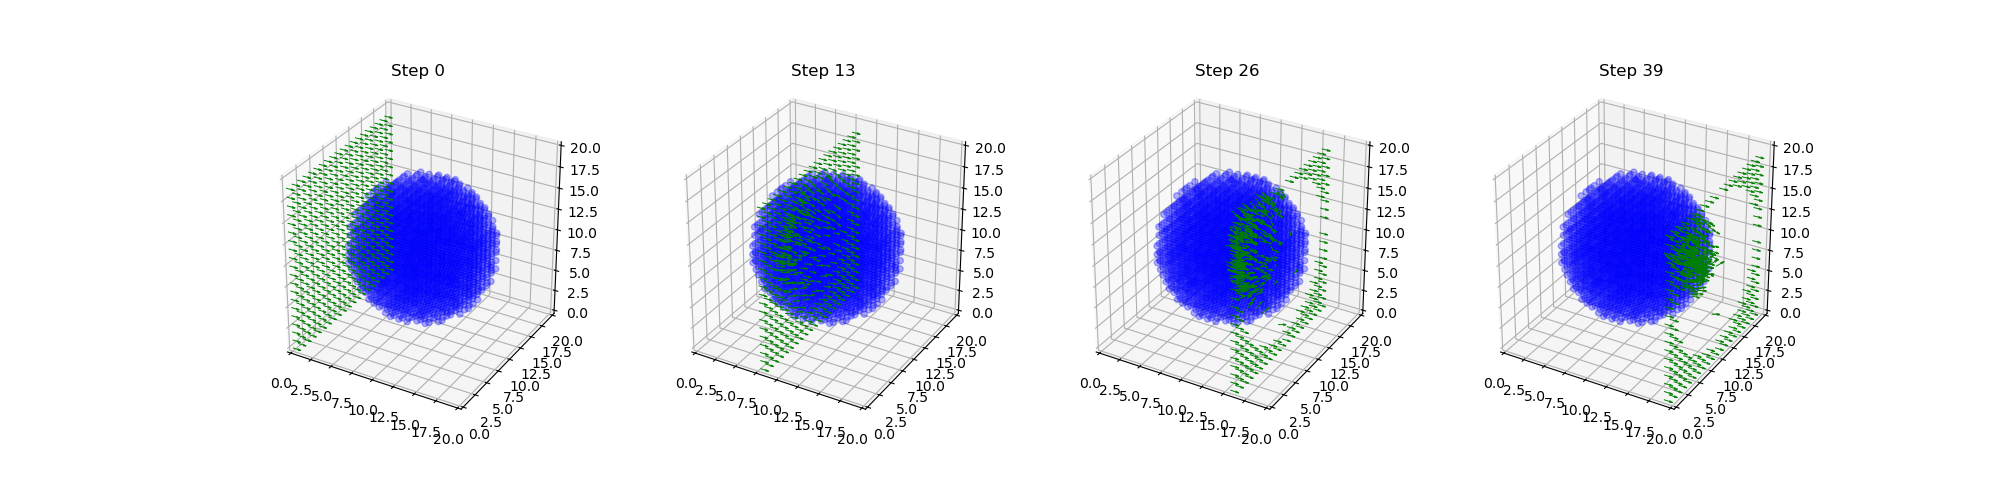

In [14]:

num_show_images = 4

def show_propagation_results(convex_pos_res, convex_dir_res, num_show_images, num_steps):
    show_indices = [i for i in range(0, num_steps, num_steps // num_show_images + 1)]
    fig = plt.figure(figsize=(5*len(show_indices), 5))
    for i in show_indices:
        ax = fig.add_subplot(1, len(show_indices), show_indices.index(i)+1, projection='3d')
        ax.set_box_aspect([1,1,1])
        ax.set_xlim(0, 20)
        ax.set_ylim(0, 20)
        ax.set_zlim(0, 20)
        ax.set_title(f"Step {i}")
        # 3D IOR field
        x_points, y_points, z_points = np.where(convex_lens_ior_field == 1.5)
        ax.scatter(x_points, y_points, z_points, color='blue', alpha=0.3)

        # Wavefront
        wavefront_positions = np.array(convex_pos_res[i])
        wavefront_directions = np.array(convex_dir_res[i])
        ax.quiver(wavefront_positions[:, 0], wavefront_positions[:, 1], wavefront_positions[:, 2], 
                wavefront_directions[:, 0], wavefront_directions[:, 1], wavefront_directions[:, 2],
                length=1, color='green', normalize=True, linewidths=0.7, arrow_length_ratio=0.4)
    plt.show()

show_propagation_results(convex_pos_res, convex_dir_res, num_show_images, test_num_steps)